<a href="https://colab.research.google.com/github/Hayeoniiii/CIFAR-10-Classification/blob/main/with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # degree: 회전, translate: 이동, scale: 줌
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

num_train = len(full_train_set)  # 50000
val_size = 10000
train_size = num_train - val_size

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
val_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_val)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:16<00:00, 10.4MB/s]


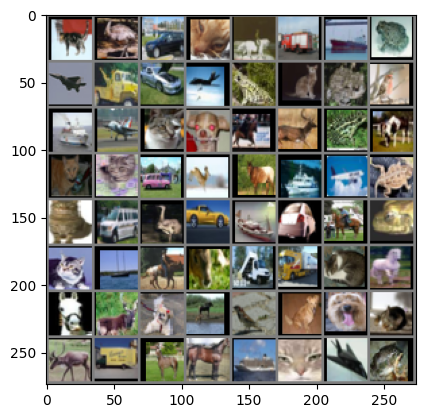

cat   bird  car   cat   horse truck ship  frog  plane truck car   plane frog  cat   frog  bird  ship  plane cat   dog   horse deer  frog  horse cat   cat   car   deer  horse ship  plane frog  cat   car   bird  car   ship  car   horse frog  cat   ship  horse deer  truck truck cat   horse horse deer  dog   deer  bird  dog   dog   cat   deer  truck horse horse ship  cat   plane frog 


In [4]:
def imshow(img):
  img = img / 2 + 0.5 # unnormarlize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
    self.bn1_1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
    self.bn1_2 = nn.BatchNorm2d(32)

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
    self.bn2_1 = nn.BatchNorm2d(64)
    self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
    self.bn2_2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
    self.bn3 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(128 * 4 * 4, 256)
    self.bn_fc1 = nn.BatchNorm1d(256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.bn1_1(self.conv1_1(x)))
    x = self.pool(F.relu(self.bn1_2(self.conv1_2(x))))
    x = F.relu(self.bn2_1(self.conv2_1(x)))
    x = self.pool(F.relu(self.bn2_2(self.conv2_2(x))))
    x = F.relu(self.bn3(self.conv3(x)))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.bn_fc1(self.fc1(x)))
    x = self.dropout(x)
    x = self.fc2(x) # logits
    return x

net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

num_epochs = 20

for epoch in range(num_epochs):
    net.train() # 학습 모드
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs} (train)")
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        train_loss_sum += loss.item() * bs
        _, preds = outputs.max(1)
        train_correct += (preds == labels).sum().item()
        train_total += bs

        curr_loss = train_loss_sum / train_total
        curr_acc = train_correct / train_total * 100
        pbar.set_postfix(train_loss=f"{curr_loss:.4f}", train_acc=f"{curr_acc:.2f}%")

    train_loss = train_loss_sum / train_total
    train_acc = train_correct / train_total * 100


    net.eval() # 검증 모드
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        pbar_val = tqdm(enumerate(valloader), total=len(valloader), desc=f"Epoch {epoch+1}/{num_epochs} (val)   ")
        for i, (inputs, labels) in pbar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            val_loss_sum += loss.item() * bs
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += bs

            curr_vloss = val_loss_sum / val_total
            curr_vacc = val_correct / val_total * 100
            pbar_val.set_postfix(val_loss=f"{curr_vloss:.4f}", val_acc=f"{curr_vacc:.2f}%")

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total * 100


    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | "
          f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

print("Finished Training")


Epoch 1/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/20] train_loss: 1.5116 | train_acc: 45.52% | val_loss: 1.1073 | val_acc: 60.42%


Epoch 2/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/20] train_loss: 1.1461 | train_acc: 59.15% | val_loss: 0.9046 | val_acc: 68.18%


Epoch 3/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/20] train_loss: 1.0075 | train_acc: 64.52% | val_loss: 0.9030 | val_acc: 68.44%


Epoch 4/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/20] train_loss: 0.9211 | train_acc: 67.99% | val_loss: 0.7337 | val_acc: 74.29%


Epoch 5/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/20] train_loss: 0.8594 | train_acc: 69.88% | val_loss: 0.6922 | val_acc: 75.33%


Epoch 6/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/20] train_loss: 0.8116 | train_acc: 71.77% | val_loss: 0.6726 | val_acc: 76.31%


Epoch 7/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/20] train_loss: 0.7722 | train_acc: 72.93% | val_loss: 0.6294 | val_acc: 77.81%


Epoch 8/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/20] train_loss: 0.7418 | train_acc: 74.17% | val_loss: 0.5868 | val_acc: 79.21%


Epoch 9/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 9/20] train_loss: 0.7131 | train_acc: 75.06% | val_loss: 0.5685 | val_acc: 80.27%


Epoch 10/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10/20] train_loss: 0.6877 | train_acc: 76.22% | val_loss: 0.5115 | val_acc: 82.09%


Epoch 11/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 11/20] train_loss: 0.6691 | train_acc: 76.58% | val_loss: 0.5084 | val_acc: 82.27%


Epoch 12/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 12/20] train_loss: 0.6452 | train_acc: 77.50% | val_loss: 0.4875 | val_acc: 82.96%


Epoch 13/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 13/20] train_loss: 0.6288 | train_acc: 78.05% | val_loss: 0.4693 | val_acc: 83.51%


Epoch 14/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 14/20] train_loss: 0.6128 | train_acc: 78.91% | val_loss: 0.4553 | val_acc: 83.96%


Epoch 15/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 15/20] train_loss: 0.5979 | train_acc: 79.22% | val_loss: 0.4548 | val_acc: 84.24%


Epoch 16/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 16/20] train_loss: 0.5859 | train_acc: 79.50% | val_loss: 0.4292 | val_acc: 84.95%


Epoch 17/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 17/20] train_loss: 0.5702 | train_acc: 80.26% | val_loss: 0.4442 | val_acc: 84.35%


Epoch 18/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 18/20] train_loss: 0.5616 | train_acc: 80.61% | val_loss: 0.4331 | val_acc: 84.81%


Epoch 19/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 19/20] train_loss: 0.5583 | train_acc: 80.77% | val_loss: 0.3955 | val_acc: 86.26%


Epoch 20/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 20/20] train_loss: 0.5423 | train_acc: 81.18% | val_loss: 0.3887 | val_acc: 86.57%
Finished Training


In [8]:
net.eval()  # 평가 모드
test_loss_sum = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # 기울기 계산 비활성화
    pbar_test = tqdm(enumerate(testloader), total=len(testloader), desc="Test")
    for i, (inputs, labels) in pbar_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        bs = labels.size(0)
        test_loss_sum += loss.item() * bs
        _, preds = outputs.max(1)
        test_correct += (preds == labels).sum().item()
        test_total += bs

        pbar_test.set_postfix(
            test_loss=f"{test_loss_sum/test_total:.4f}",
            test_acc=f"{100*test_correct/test_total:.2f}%"
        )

test_loss = test_loss_sum / test_total
test_acc  = 100 * test_correct / test_total
print(f"[Test] loss: {test_loss:.4f} | acc: {test_acc:.2f}%")

Test:   0%|          | 0/157 [00:00<?, ?it/s]

[Test] loss: 0.4798 | acc: 83.49%
